In [1]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [2]:
!kaggle competitions download -c contradictory-my-dear-watson

  0% 0.00/66.0k [00:00<?, ?B/s]
100% 66.0k/66.0k [00:00<00:00, 61.9MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 83.8MB/s]
  0% 0.00/536k [00:00<?, ?B/s]
100% 536k/536k [00:00<00:00, 75.3MB/s]


In [25]:
import os
import numpy as np
import random
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import plotly.express as px
!pip install googletrans
from googletrans import Translator
!pip uninstall -y transformers
!pip install transformers

import transformers
import tokenizers

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


import datetime

strategy = None

Uninstalling transformers-3.1.0:
  Successfully uninstalled transformers-3.1.0
  Using cached https://files.pythonhosted.org/packages/ae/05/c8c55b600308dc04e95100dc8ad8a244dd800fe75dfafcf1d6348c6f6209/transformers-3.1.0-py3-none-any.whl


In [35]:
def translate2english(text):
    translator = Translator()
    return translator.translate(text, dest = "en").text

In [16]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [26]:
original_train = pd.read_csv("train_en")

In [56]:
from tqdm import tqdm
tqdm.pandas()

In [110]:
original_train.loc[(original_train['lang_abv'] != 'en'),'premise']=original_train['premise'].progress_apply(lambda x: translate2english(x))
original_train.loc[(original_train['language'] != 'English'),'hypothesis']=original_train['hypothesis'].progress_apply(lambda x: translate2english(x))

100%|██████████| 12120/12120 [25:14<00:00,  8.00it/s]


In [27]:
test = pd.read_csv("test_en")

In [ ]:
test.loc[(test['lang_abv'] != 'en'),'premise']=test['premise'].progress_apply(lambda x: translate2english(x))
test.loc[(test['language'] != 'English'),'hypothesis']=test['hypothesis'].progress_apply(lambda x: translate2english(x))

In [16]:
test.head(10)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language
0,0,c6d58c3f69,"The boxes will be named after Box, Casey, Rach...","There will be no memorial for Casey, one of Co...",ur,Urdu
1,1,cefcc82292,This is what we were advised to do.,"When they are told what to do, the administrat...",ar,Arabic
2,2,e98005252c,and this is largely due to the fact that mothe...,Mothers take drugs.,fr,French
3,3,58518c10ba,Dialogue with representatives of cities and ot...,IMA cooperates with other organizations becaus...,zh,Chinese
4,4,c32b0d16df,She was still there.,"We thought that she left, however, she stayed.",ru,Russian
5,5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English
7,7,a16f7ed56b,It was probably the first thing I remembered f...,It was one of my earliest memories.,fr,French
8,8,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English
9,9,c156e8fed5,No one knew where they went.,Their arrival was a secret,sw,Swahili


In [17]:
original_train.head(10)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1
5,5,ed7d6a1e62,You might hear someone on a farm saying we sho...,People on the farm use different terms.,tr,Turkish,0
6,6,5a0f4908a0,"On his return to the United States, Hajj met a...",The Hague was investigated by FBI agents,ur,Urdu,0
7,7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1
9,9,8c10229663,"Every hundred degrees, paint spots change colo...",The paint changes to match the color.,ru,Russian,0


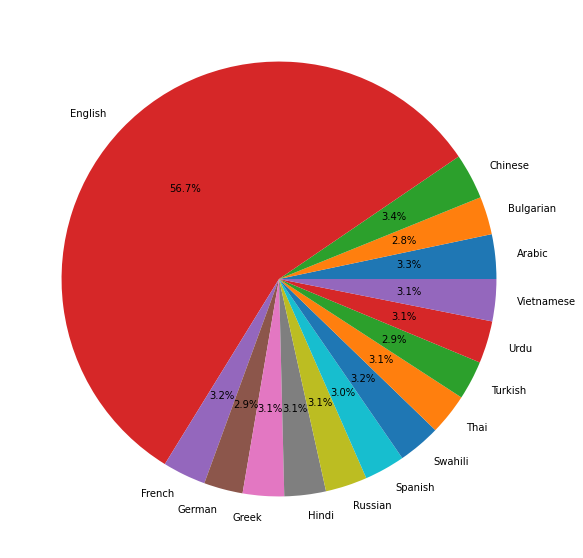

In [115]:
labels, frequencies = np.unique(original_train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

# Check TPU devices

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.127.229.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.229.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [28]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.127.229.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.229.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.229.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [7]:
"""bert
from transformers import BertTokenizer, TFBertModel
model_name = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
"""

In [29]:
from transformers import AutoTokenizer, TFXLMRobertaModel
model_name="jplu/tf-xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model =TFXLMRobertaModel.from_pretrained(model_name)

Some weights of the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [24]:
transformers.__version__

'3.1.0'

In [30]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)
encode_sentence("My name is watson.")

[2646, 9351, 83, 793, 1681, 5, 3]

In [31]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]# classification task
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

train_input = bert_encode(original_train.premise.values, original_train.hypothesis.values, tokenizer)

In [120]:
train_input['input_word_ids']

<tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
array([[  101, 10111, 11762, ...,     0,     0,     0],
       [  101, 13252, 10301, ...,     0,     0,     0],
       [  101, 12936, 24682, ...,     0,     0,     0],
       ...,
       [  101, 10117, 12452, ...,     0,     0,     0],
       [  101, 11699, 10105, ...,     0,     0,     0],
       [  101, 11399, 14764, ...,     0,     0,     0]], dtype=int32)>

In [32]:
max_len = 50

def build_model():
    bert_encoder = TFXLMRobertaModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]#output of bert
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  #define optimization way, loss function, and metrics.
    
    return model

In [33]:
with strategy.scope():#各TPUごとに処理
    model = build_model()
    model.summary()

Some weights of the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model_3 (TFXLMRob ((None, 50, 768), (N 278043648   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
model.fit(train_input, original_train.label.values, epochs = 200, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/200


  2/152 [..............................] - ETA: 42:06 - loss: 1.2100 - accuracy: 0.3281  WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0084s vs `on_train_batch_end` time: 0.1976s). Check your callbacks.


152/152 [==============================] - ETA: 0s - loss: 1.1040 - accuracy: 0.4039WARNING:tensorflow:Model was constructed with shape (None, 50) for input Tensor("input_word_ids_1:0", shape=(None, 50), dtype=int32), but it was called on an input with incompatible shape (None, 245).


152/152 [==============================] - 119s 782ms/step - loss: 1.1040 - accuracy: 0.4039 - val_loss: 0.9102 - val_accuracy: 0.5648
Epoch 2/200
152/152 [==============================] - 34s 222ms/step - loss: 0.8590 - accuracy: 0.6162 - val_loss: 0.7787 - val_accuracy: 0.6799
Epoch 3/200
152/152 [==============================] - 34s 223ms/step - loss: 0.6906 - accuracy: 0.7136 - val_loss: 0.7193 - val_accuracy: 0.7149
Epoch 4/200
152/152 [==============================] - 34s 224ms/step - loss: 0.5773 - accuracy: 0.7715 - val_loss: 0.6761 - val_accuracy: 0.7318
Epoch 5/200
152/152 [==============================] - 34s 223ms/step - loss: 0.4765 - accuracy: 0.8157 - val_loss: 0.7798 - val_accuracy: 0.7298
Epoch 6/200
152/152 [==============================] - 34s 223ms/step - loss: 0.3959 - accuracy: 0.8502 - val_loss: 0.8417 - val_accuracy: 0.7257
Epoch 7/200
105/152 [===================>..........] - ETA: 9s - loss: 0.3169 - accuracy: 0.8851 

In [ ]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)
labels, frequencies = np.unique(test.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [ ]:
test.head()
predictions = [np.argmax(i) for i in model.predict(test_input)]
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()


,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


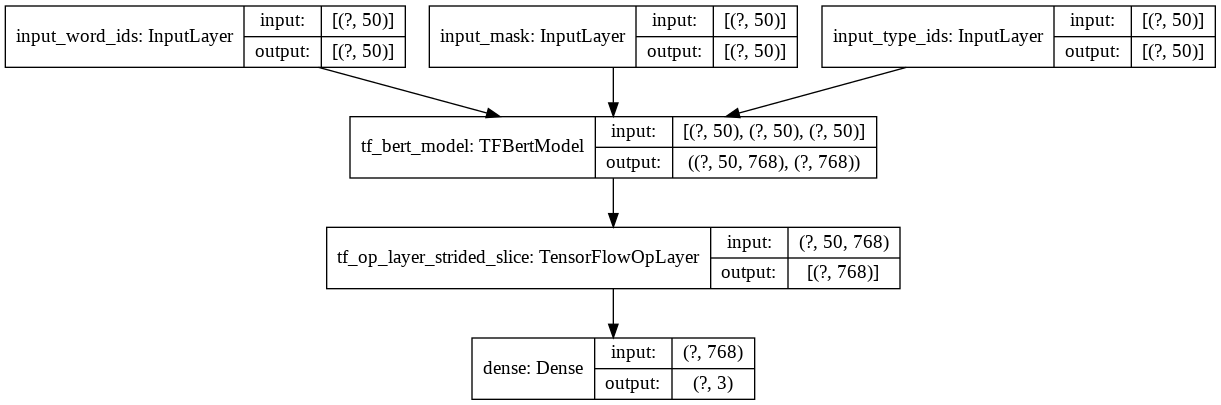

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [144]:
AutoModelWithLMHead.from_pretrained(model_name).config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 119547
}

In [ ]:
[print(tokenizer.convert_ids_to_tokens(int(i)),", ",end="") for i in train_input['input_word_ids'][2].numpy() ] 

In [ ]:
original_train.head(20)

,id,premise,hypothesis,lang_abv,language,label
11899,9e387ddc0e,"As it is now, Web companies not only have the ...",Web companies use this advantage to assist tho...,en,English,1
11773,06e4c7465f,The only comprehensible explanation is that th...,The only explanation is that nothing has taken...,en,English,2
10029,13b25863e3,Если вы найдете имена Peculiar (Миссури) или т...,"Сурпрайз — населенный пункт в штате Небраска, ...",ru,Russian,0
3427,00b23f5bb3,и еще это заставит людей компактнее складывать...,"Люди, ограничивающие количество мусора, являют...",ru,Russian,0
11515,981ce3a391,"4 million homes watch the evening news on CBS,...","CBS, ABC and NBC are the leaders in news.",en,English,1
5717,8412e2ea58,انسانی دیکھ بھال کے ساتھ ساتھ جنگل میں بھی ہات...,یہ ہر جگہ ہاتھوں کی مدد کرے گا.,ur,Urdu,0
1145,446e09261b,well um i uh exercise regularly i work at a un...,I am a fit person with 1.4% body fat.,en,English,1
5400,2f64d4f23a,the hologram makes up all these things and uh ...,We have nothing to do but stare at the walls t...,en,English,2
5030,ec65bff4f8,"A proserous tourist district, it is full of sh...",The rich tourist district has shopping centers...,en,English,0
7933,a1839531f3,Hamon said the proposed bill has attracted a n...,The proposed bill would make Legal Aid accessi...,en,English,1
